## Organisation

### Deadlines:
- Project report: 28.05.2023, 23:59
- Presentation: 31.05.2023
- small changes

### General to-do list:
- [ ] keep track of the values of evaluation metrics (Excel spreadsheet)
- [ ] to go through TO-DO-s in the code and fix it
- [ ] documentation: leave comments in the notebook
- [ ] select the date to attend a coaching session + send an email to the tutors about it
- [ ] check out the 'helper' notebook here: https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem 
- [ ] Compare results with other notebooks

### Code-related to-do list:

- [ ] add box plots for identifying outliers
- [ ] hyperparameter optimization (e.g. max depth in decision tree)
- [ ] cross - validation
- [ ] add cost matrix or think about other way to punish false negatives (e.g. look at medical scientific papers)
- [ ] add boosted trees (XGBoost
, GBM, LightGBM) https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
- [ ] search for some 'official' guidelines for diagnosing diabetes and comparing our best model logic to these guidelines. See: https://www.diabetes.org.uk/professionals/position-statements-reports/diagnosis-ongoing-management-monitoring/new_diagnostic_criteria_for_diabetes
- [ ] think about how to deal with medical features (e.g. glucose level, etc.): maybe binning/encoding (e.g. separate values for level which is normal, lower, higher than norm)
Normal : HbA1C (5.7%> x >6.5%), Blood Glucose (fasting) (99 > x > 126 mg/dL)t
- [ ] Clusters - Type 1 and Type 2 diabetes. We (the dataset) do not differentiate Type1 and Type2. We could try to build clusters and make assumptions/possible interpretations of which type the clusters could be
- [ ] understand the preprocessing in FastAI neural network and try it out for other models AND apply our own preprocessing to this neural network model

### Structure of the notebook:

Exploratory Data Analysis
- data metrics
- distributions of attributes (maybe from the helper notebook, experiment with bin width)
- correlation? (what we would do with the result of correlation analysis? are we going to conduct feature relevance evaluation? by the way, in the report we could say that in case of a very high correlation we would consider to remove one of such features to avoid collinearity)
- box plots for identifying outliers (in the helper notebook) - maybe violin plots?
2. Preprocessing
- Handle missing values (probably exclude such entries. In the paper we could also discuss the approach with median/mean). If we don't exclude -> using univariate imputation (mean/median/mode) would be more appropriate than multivariate imputation (model feature 'smoking_history' as a function of other features - makes no sense for our dataset). In KNN -> check KNNImputer
- encoding (for the ’gender’ feature we will create a new attribute for every distinct value, while in case of the ’smoking history’ we might use the ordinal encoder - unlike gender, the heaviness of the smoking habit could be represented with ordinal values)
- Handle outliers. Mainly outlier in age -> we could omit it.
- normalisation (try both MinMaxScaler and StandardScaler) (e.g. using binning - see DM_Exercise_3, MinMaxScaler, please refer to exercise 02)
- Split data: train and test (balance training data) - use stratified c-v (https://www.kaggle.com/code/mohamedkhaled2007/diabetes-prediction-mkma-stack?scriptVersionId=125802796&cellId=21)
- balancing (DM_Ex_4) (The  approaches  we  consider  are:  to  use oversampling technique, to use under sampling, maybe combined approach, or stratified sampling in c-val)
3. Models
- Stratified cross-validation (DM_Ex_4)
- hyperparameter tuning (Grid search) (DM_Ex_5 provides a nice example of both hyper parameter tuning and cross-val)
- Logistic regression - https://www.kaggle.com/code/funxexcel/p2-logistic-regression-hyperparameter-tuning
- KNN - handling missing values with KNNImputer (mean of the K nearest neighbors)
- Naive-Bayes?
- Decision tree
- Random forests 
- XGBoost (maybe some others?)
-SVM
- Neural networks - https://www.kaggle.com/code/ishantgargml/diabetes-prediction-96-99-accuracy-ann (to justify the use of particular neural network types)
4. Evaluation
- Confusion matrix
-Accuracy, precision, recall
- ROC Curve + AUC (one graph with ROC curves for each model)
- cost-based evaluation (DM_Ex_5). Look up other data science projects/research papers on medical data - how do they assign weights. Which unit of measure?
- make a table summarising&comparing the results of all the estimators
- Log loss? (maybe there is no point because decision trees and random forests typically do not output class probabilities, and so log loss cannot be used with these models, ergo, we won't be able to compare them with other models using this metrics)
Questions:
- When we should and should not apply the same preprocessing to the test data, should we also apply balancing techniques? We were told not to touch the test data but in DM_Exercise_3 we read: "If we want to evaluate our model on a second dataset, we must take care to apply the same preprocessing as we did for the training"
- handling missing values: exclude -> use ordinal encoder or leave it as it is -> use one hot encoder
- could stratified c-val go in combination with oversampling
- could we do slightly different preprocessing for different estimators (e.g. we would do KNNImputer for KNN and a different technique for other estimators)?

In [13]:
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [14]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    Helper function from exercise 5.
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()


In [15]:
def show_values(pc, fmt="%.2f", **kw):
    """
    Heatmap with text in each cell
    """
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    """
    Specify figure size in centimeter
    """
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, correct_orientation=False, cmap='RdBu'):

    c = plt.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    plt.yticks(np.arange(AUC.shape[0]) + 0.5, minor=False, labels = yticklabels)
    plt.xticks(np.arange(AUC.shape[1]) + 0.5, minor=False, labels = xticklabels)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)  
    plt.tight_layout()

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        plt.invert_yaxis()
        plt.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()

def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    """
    Plot scikit-learn classification report
    Using: https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
    """
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, correct_orientation, cmap=cmap)

## Exploratory Data Analysis

### Load data and glimpse at it

In [16]:
# Load dataset
df = pd.read_csv("diabetes_prediction_dataset.csv")

### Univariate exploration

In [17]:
df.duplicated().sum()


3854

In [18]:
# show the first 5 rows test again
df.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [19]:
# show data types of the dataset
df.dtypes

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

In [20]:
# show summary of the dataset
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


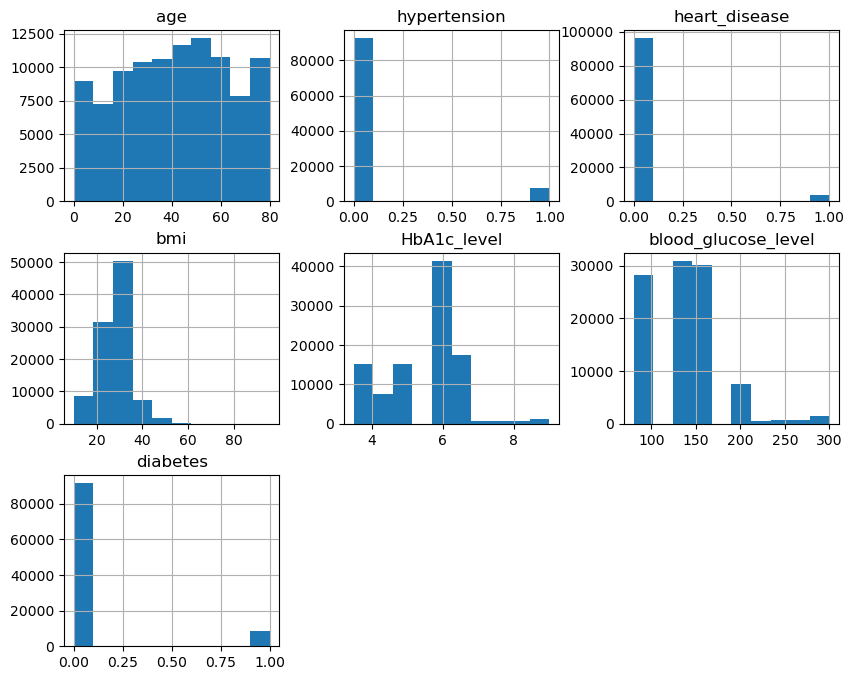

In [21]:
# show histogram of attributes (should we show this here or after encoding the gender?) // a

df.hist(figsize=(10, 8))
plt.show()

#### Identify Missing Values

In [22]:
missing_values_count = (
    df.isna().sum()
)  # TO-DO: deal with missing values in 'smoking history' /"no info"
print(missing_values_count)

# No info in smoking history is also considered as missing value
missing_smoking = df["smoking_history"].value_counts()["No Info"]
print("No info in smoking history: ", missing_smoking)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
No info in smoking history:  35816


#### Imbalanced classes

See how imbalance the data is

In [23]:
freq_table = df["diabetes"].value_counts()
print(freq_table)


0    91500
1     8500
Name: diabetes, dtype: int64


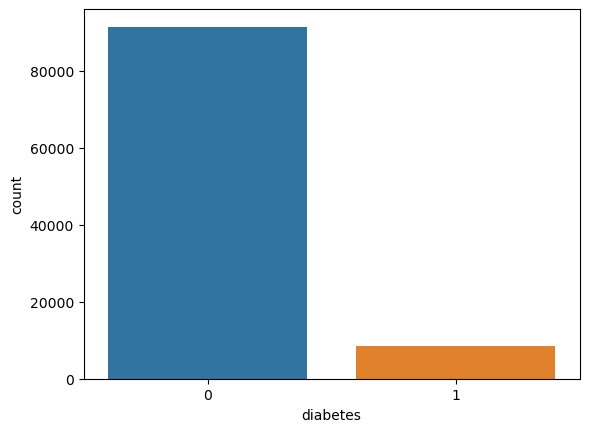

In [24]:
sns.countplot(data=df, x="diabetes")
plt.show()


#### Bivariate exploration

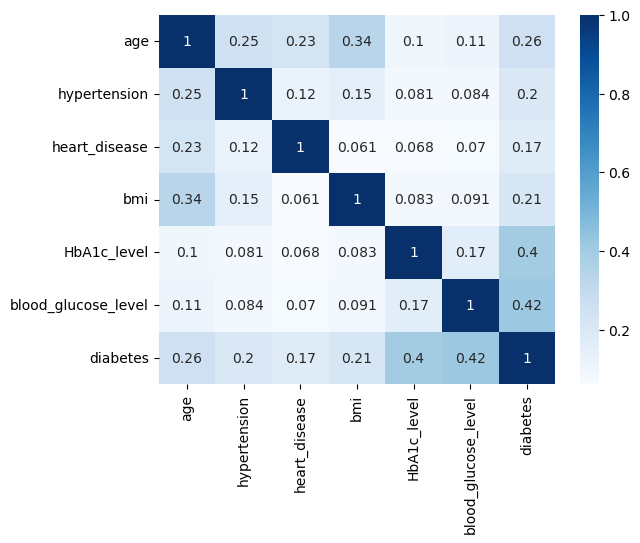

In [25]:
# compute the correlation matrix
corr_matrix = df.corr()

# plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="Blues")
plt.show()


### Cross-Validation 

### Identifying Outlier

In [26]:
# # Identify Outlier using boxplot
# # Values/attributes should be encoded first (?) // a
# plt.figure(figsize=(15,10))
# for i,col in enumerate(df.columns,1):
#     plt.subplot(4,3,i)
#     plt.title(f"Distribution of {col} Data")
#     sns.boxplot(df[col])
#     plt.tight_layout()
#     plt.plot()


## Preprocessing

### Baseline

In [27]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict

In [28]:
numeric_features = [
    "age",
    "hypertension",
    "heart_disease",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("balancing", RandomOverSampler()),
        ("estimator", DecisionTreeClassifier(max_depth=7, random_state=42)),
    ]
)

# Prepare data
X = df.drop("diabetes", axis=1)
y = df["diabetes"]

# Prepare target labels
labeler = LabelEncoder()
labeler.fit(y)
y = labeler.transform(y)
label_names = ["Negative", "Positive"]
label_order = [0, 1]

# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [29]:
df["gender"].value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

In [30]:
# Encode gender
label_encoder = preprocessing.LabelEncoder()
df["gender"] = label_encoder.fit_transform(df["gender"])
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,No Info,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0


## Baseline Models

In [31]:
def run_baseline(estimator, X_train, X_test, y_train, y_test):
    # Train and predict
    pipeline.set_params(estimator=estimator)
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)

    # Compute metrics
    cm = confusion_matrix(y_test, prediction, labels=label_order)

    # Plot
    plot_confusion_matrix(cm, classes=label_names, title=type(estimator).__name__)
    plt.show()
    print(classification_report(y_test, prediction, target_names=label_names))

###  Decision Tree

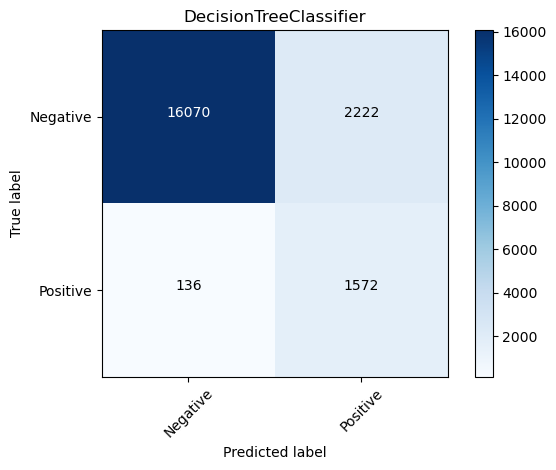

              precision    recall  f1-score   support

    Negative       0.99      0.88      0.93     18292
    Positive       0.41      0.92      0.57      1708

    accuracy                           0.88     20000
   macro avg       0.70      0.90      0.75     20000
weighted avg       0.94      0.88      0.90     20000



In [32]:
estimator = DecisionTreeClassifier(max_depth=7, random_state=42)
run_baseline(estimator, X_train, X_test, y_train, y_test)


#### Plot decision tree

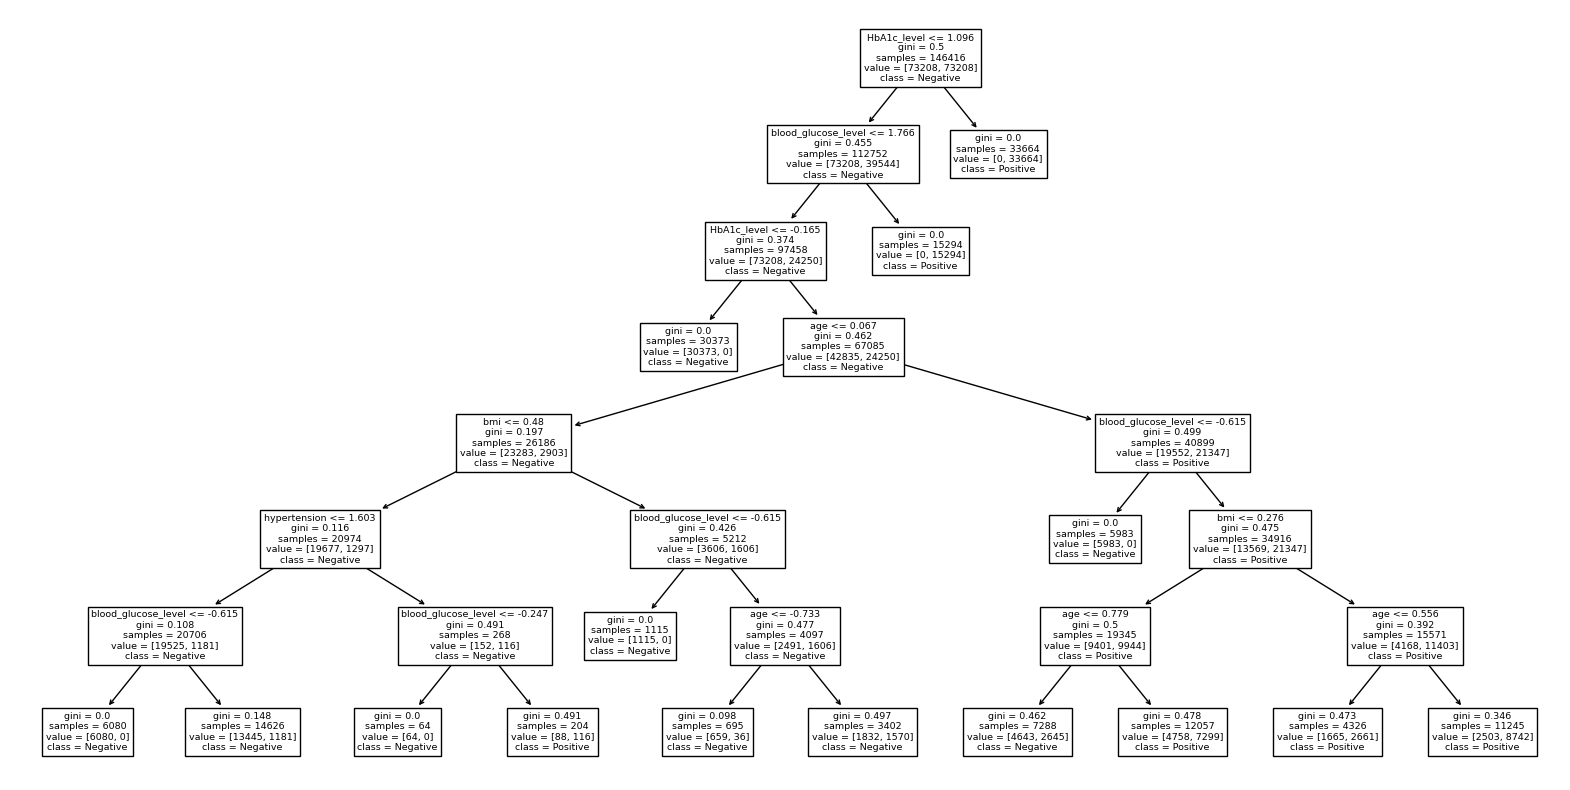

In [33]:
from sklearn import tree

plt.figure(figsize=(20, 10))
tree.plot_tree(estimator, feature_names=numeric_features, class_names=label_names)

plt.savefig("decision_tree.svg", dpi=350, format="svg")
plt.show()


#### Optimize hyperparameters

### Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100, random_state=42)
run_baseline(estimator, X_train, X_test, y_train, y_test)


KeyboardInterrupt: 

### K Nearest Neighbors

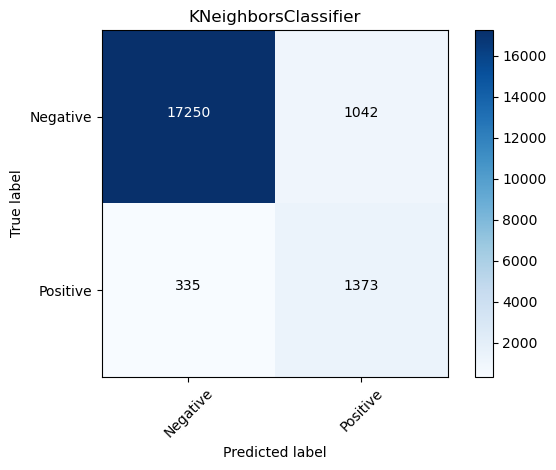

              precision    recall  f1-score   support

    Negative       0.98      0.94      0.96     18292
    Positive       0.57      0.80      0.67      1708

    accuracy                           0.93     20000
   macro avg       0.77      0.87      0.81     20000
weighted avg       0.95      0.93      0.94     20000



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=5)
run_baseline(estimator, X_train, X_test, y_train, y_test)


### Naive Bayes

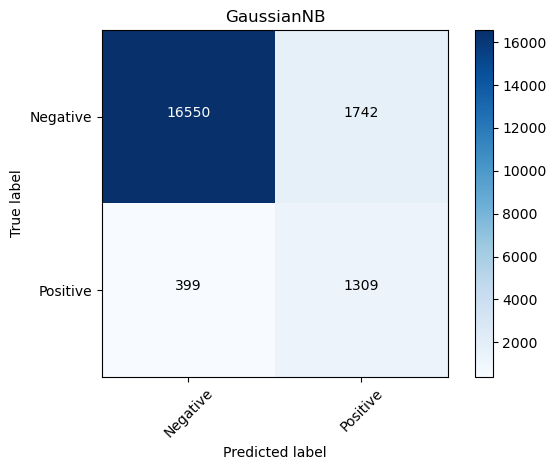

              precision    recall  f1-score   support

    Negative       0.98      0.90      0.94     18292
    Positive       0.43      0.77      0.55      1708

    accuracy                           0.89     20000
   macro avg       0.70      0.84      0.74     20000
weighted avg       0.93      0.89      0.91     20000



In [ ]:
from sklearn.naive_bayes import GaussianNB

estimator = GaussianNB()
run_baseline(estimator, X_train, X_test, y_train, y_test)


### Support Vector Machines

In [ ]:
# from sklearn.svm import SVC

# estimator = SVC()
# run_baseline(estimator, X_train, X_test, y_train, y_test)


### Neural Network

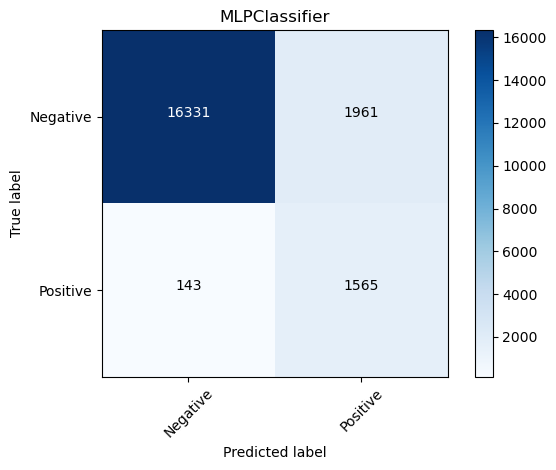

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     18292
    Positive       0.44      0.92      0.60      1708

    accuracy                           0.89     20000
   macro avg       0.72      0.90      0.77     20000
weighted avg       0.94      0.89      0.91     20000



In [ ]:
from sklearn.neural_network import MLPClassifier

estimator = MLPClassifier()
run_baseline(estimator, X_train, X_test, y_train, y_test)


### FastAI Neural Network

In [ ]:
# Fixes the issue with the progress bar in Jupyter notebooks
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch


In [ ]:
from fastai.tabular.all import *
from pathlib import Path

path = Path(".")

# Define your categorical and continuous variables
cat_vars = ["gender", "hypertension", "heart_disease"]
cont_vars = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]
y_names = "diabetes"
y_block = CategoryBlock()

# Define the preprocessing steps
procs = [Categorify, FillMissing, Normalize]

# Create a TabularDataLoaders object
dls = TabularDataLoaders.from_csv(
    path / "diabetes_prediction_dataset.csv",
    path=path,
    y_names=y_names,
    cat_names=cat_vars,
    cont_names=cont_vars,
    procs=procs,
    bs=2048,
    y_block=y_block,
)

# Learn the model
learn = tabular_learner(dls, metrics=F1Score(average="macro"), y_range=(0, 1))
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,f1_score,time
0,0.645752,0.606065,0.658040,00:01
1,0.575061,0.483282,0.732521,00:00
2,0.502065,0.401824,0.831588,00:01
3,0.439095,0.370077,0.872397,00:00
4,0.397936,0.359115,0.881414,00:00
5,0.374439,0.353175,0.885624,00:00
6,0.361919,0.351164,0.886075,00:00
7,0.355081,0.349970,0.885936,00:00
8,0.351315,0.349397,0.886756,00:00
9,0.349592,0.349411,0.886673,00:00


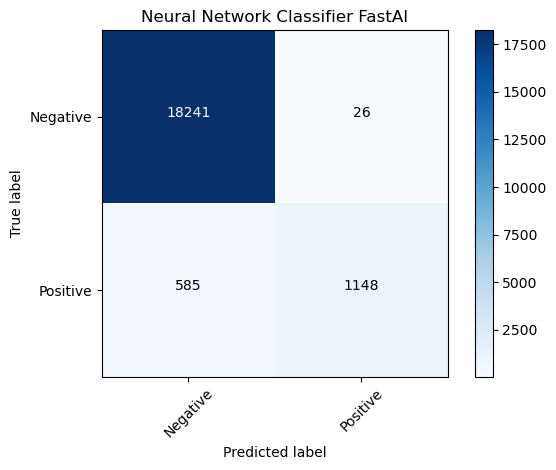

In [ ]:
# Get predictions
preds, targets = learn.get_preds(dl=dls.valid)
predicted_classes = preds.argmax(dim=1)

# Plot confusion matrix
cm = confusion_matrix(targets, predicted_classes, labels=label_order)
plot_confusion_matrix(cm, classes=label_names, title="Neural Network Classifier FastAI")
plt.show()


In [ ]:
# Report metrics
print(classification_report(targets, predicted_classes))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18267
           1       0.98      0.66      0.79      1733

    accuracy                           0.97     20000
   macro avg       0.97      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000



### Logistic Regression

we could try: https://www.kaggle.com/code/anubhav012/diabetes-prediction-eda-model-score-0-9724?scriptVersionId=128635440&cellId=52 

try to adjust parameter to: newton-cholesky (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and penalty to L2 (all features relevant to prediction)

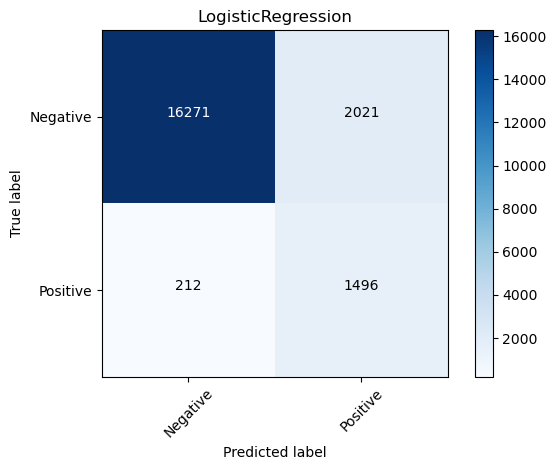

              precision    recall  f1-score   support

    Negative       0.99      0.89      0.94     18292
    Positive       0.43      0.88      0.57      1708

    accuracy                           0.89     20000
   macro avg       0.71      0.88      0.75     20000
weighted avg       0.94      0.89      0.90     20000

test


In [ ]:
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
run_baseline(estimator, X_train, X_test, y_train, y_test)
print("test")

# acc = roc_auc_score(y_train, y_test)
# print("ROC AUC Score : ", acc)

### Gradient Boosting Classifier

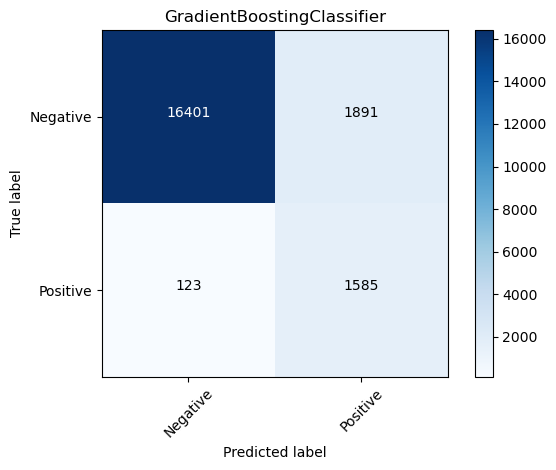

              precision    recall  f1-score   support

    Negative       0.99      0.90      0.94     18292
    Positive       0.46      0.93      0.61      1708

    accuracy                           0.90     20000
   macro avg       0.72      0.91      0.78     20000
weighted avg       0.95      0.90      0.91     20000



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

estimator = GradientBoostingClassifier()
run_baseline(estimator, X_train, X_test, y_train, y_test)

## Optimize Hyperparameters and preprossecing

In [ ]:
# Preprocessing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import feature_selection, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    make_scorer, 
    fbeta_score,
)


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

# Progress bar
from tqdm.auto import tqdm

import pandas as pd

numeric_features = [
    "age",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
]

nominal_features = [
    "hypertension",
    "heart_disease",
    "gender",
    "smoking_history",
]

ordinal_features = [
    # "smoking_history",
]

estimators: list[dict] = [
    {
        "estimator": KNeighborsClassifier(),
        "parameters":{
            "estimator__n_neighbors": [3, 5, 7, 9, 11]},
            "estimator__weights": ["uniform", "distance"],
            "estimator__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    },
    {
        "estimator": LogisticRegression(max_iter=5000),
        "parameters": {
            "estimator__C": [0.1, 1, 10, 100],
            "estimator__penalty": ["l1", "l2"],
            "estimator__solver": ["liblinear", "saga"],
        },
    },
    {
        "estimator": DecisionTreeClassifier(),
        "parameters": {
            "estimator__max_depth": [3, 5, 7, 9, 11],
            "estimator__criterion": ["gini", "entropy"],
            "estimator__splitter": ["best", "random"],
        },
    },
    {
        "estimator": RandomForestClassifier(),
        "parameters": {
            "estimator__max_depth": [3, 7, 11],
            "estimator__criterion": ["gini", "entropy"],
            "estimator__n_estimators": [100, 500],
        },
    },
    {
        "estimator": GaussianNB(),
        "parameters": {"estimator__var_smoothing": [1e-09, 1e-08, 1e-07, 1e-06]},
    },
    {
        "estimator": MLPClassifier(),
        "parameters": {
            "estimator__hidden_layer_sizes": [(50,), (100,), (100, 100)],
            # "estimator__max_iter": [1000],
        },
    },
    {
        "estimator": GradientBoostingClassifier(),
        "parameters": {
            "estimator__n_estimators": [100, 500],
            "estimator__learning_rate": [0.01, 1],
            "estimator__max_depth": [3, 7],
        },
    },
    {
        "estimator": AdaBoostClassifier(),
        "parameters": {"estimator__n_estimators": [100, 300, 500]},
    },
    {
        "estimator": SVC(),
        "parameters": {
            "estimator__C": [0.1, 1, 10, 100],
            "estimator__kernel": ["linear", "poly", "rbf", "sigmoid"],
        },  
    },
    {
        "estimator": XGBClassifier(),
        "parameters": {
            "estimator__n_estimators": [100, 500],
            "estimator__max_depth": [3, 7, 11],
        },
    },
]

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler(),
}

samplers = {
    "OverSampler": RandomOverSampler(),
    "UnderSampler": RandomUnderSampler(),
    # "CombinedSampler": SMOTEENN(random_state=0),
    "passtrough": "passthrough",
}

clusterers = {
    "KMeans": KMeans(n_clusters=3, n_init="auto", random_state=42),
    "passthrough": "passthrough",
}

feature_selections = {
    "passthrough": "passthrough",
    "SelectKBest": feature_selection.SelectKBest(),
    "SelectPercentile": feature_selection.SelectPercentile(),
    "SelectFpr": feature_selection.SelectFpr(),
}

interaction_features = {
    "passthrough": "passthrough",
    "PolynomialFeatures": preprocessing.PolynomialFeatures(degree=2, include_bias=False),
}

# Prepare data
df = pd.read_csv("diabetes_prediction_dataset.csv")
X = df.drop("diabetes", axis=1)
y = df["diabetes"]


labeler = LabelEncoder()
labeler.fit(y)
y = labeler.transform(y)
label_names = ["Negative", "Positive"]
label_order = [0, 1]

fraction = 0.01
X_eval, X_sel, y_eval, y_sel = train_test_split(
    X, y, test_size=fraction, random_state=42
)
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_sel, y_sel, test_size=0.2, random_state=42
)


verbose = False

# For progress bars
est_loop = tqdm(estimators, desc="Estimators")
scaler_loop = tqdm(scalers.items(), desc="Scalers")
sampler_loop = tqdm(samplers.items(), desc="Samplers")
clusterer_loop = tqdm(clusterers.items(), desc="Clusterer")
feature_selection_loop = tqdm(feature_selections.items(), desc="Feature Selection")
interaction_features_loop = tqdm(interaction_features.items(), desc="Interaction Features")


# Load previously saved results (if any)
file_name = f"results_p{str(fraction).replace('.', '')}.csv"
try:
    previous_results = pd.read_csv(file_name)  # Update the file name accordingly
except FileNotFoundError:
    previous_results = pd.DataFrame()
new_results = []

scorer = make_scorer(fbeta_score, beta=2)

for estimator in estimators:
    # for progress bars
    est_name = estimator.get("estimator").__class__.__name__
    est_loop.set_description(
        f"Estimator: {est_name}"
    )
    scaler_loop.refresh()
    scaler_loop.reset()
    est_loop.update()

    for scaler_name, scaler in scalers.items():
        # for progress bars
        scaler_loop.set_description(f"Scaler: {scaler_name}")
        sampler_loop.refresh()
        sampler_loop.reset()
        scaler_loop.update()

        for sampler_name, sampler in samplers.items():
            # for progress bars
            sampler_loop.set_description(f"Sampler: {sampler_name}")
            clusterer_loop.refresh()
            clusterer_loop.reset()
            sampler_loop.update()

            for clusterer_name, clusterer in clusterers.items():
                # for progress bars
                clusterer_loop.set_description(f"Clusterer: {clusterer_name}")
                feature_selection_loop.refresh()
                feature_selection_loop.reset()
                clusterer_loop.update()

                for feature_selection_name, feature_selector in feature_selections.items():
                    # for progress bars
                    feature_selection_loop.set_description(f"Feature Selection: {feature_selection_name}")
                    interaction_features_loop.refresh()
                    interaction_features_loop.reset()
                    feature_selection_loop.update()

                    for interaction_features_name, interaction_feature in interaction_features.items():
                        # for progress bars
                        interaction_features_loop.set_description(f"Interaction Features: {interaction_features_name}")
                        interaction_features_loop.refresh()

                        # Check if the combination already exists in previous results
                        if not previous_results.empty:
                            exists = previous_results[
                                (previous_results["Estimator"] == est_name)
                                & (previous_results["Scaler"] == scaler_name)
                                & (previous_results["Sampler"] == sampler_name)
                                & (previous_results["Clusterer"] == clusterer_name)
                                & (previous_results["Feature Selector"] == feature_selection_name)
                                & (previous_results["Interaction feature"] == interaction_features_name)
                            ].any(axis=None)
                            if exists:
                                continue  # Skip the current combination


                        # Create pipeline
                        column_encoder = ColumnTransformer(
                            transformers=[
                                ("nom", OneHotEncoder(), nominal_features),
                                ("ord", OrdinalEncoder(), ordinal_features),
                                ("num", scaler, numeric_features),
                            ]
                        )

                        pipeline = Pipeline(
                            [
                                ("encoder", column_encoder),
                                ("interaction_features", interaction_feature),
                                ('variance_threshold', VarianceThreshold(threshold=0.01)), 
                                ("balancing", sampler),
                                ("feature_selector", feature_selector),
                                ("clusterer", clusterer),
                                ("estimator", estimator.get("estimator")),
                            ]
                        )

                        # Create cross-validation object
                        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

                        # Grid search for best hyper-parameters
                        parameters = estimator.get("parameters")
                        grid_search_estimator = GridSearchCV(
                            pipeline, parameters, cv=cv, scoring=scorer, n_jobs=-1
                        )
                        grid_search_estimator.fit(X_train_sel, y_train_sel)

                        # Print estimator information
                        if verbose:
                            print(
                                f"Estimator: {estimator.get('estimator')}"
                                f"Parameters: {parameters}"
                                f"Scaler: {scaler}"
                                f"Sampler: {sampler}"
                                f"Clusterer: {clusterer}"
                                f"Feature selection: {feature_selector}"
                                f"Interaction feature generator: {interaction_feature}"
                            )

                        # Print best hyper-parameters
                        if verbose:
                            print(grid_search_estimator.best_params_)
                            print(grid_search_estimator.best_score_)

                        # Compute metrics
                        prediction = grid_search_estimator.predict(X_test_sel)
                        if verbose:
                            print(classification_report(y_test_sel, prediction))

                        # Save output in a file for later analysis
                        report_dict: dict = classification_report(
                            y_test_sel, prediction, output_dict = True
                        ) # type: ignore

                        new_results.append(
                            {
                                "Estimator": est_name,
                                "parameters": {
                                    k.replace("estimator__", ""): v
                                    for k, v in estimator.get("parameters").items()
                                },
                                "best_params": {
                                    k.replace("estimator__", ""): v
                                    for k, v in grid_search_estimator.best_params_.items()
                                },
                                "Scaler": scaler_name,
                                "Sampler": sampler_name,
                                "Clusterer": clusterer_name,
                                "Feature Selector": feature_selection_name,
                                "Interaction feature": interaction_features_name,
                                "0_precision": report_dict["0"]["precision"],
                                "0_recall": report_dict["0"]["recall"],
                                "0_f1-score": report_dict["0"]["f1-score"],
                                "1_precision": report_dict["1"]["precision"],
                                "1_recall": report_dict["1"]["recall"],
                                "1_f1-score": report_dict["1"]["f1-score"],
                                "macro_avg_precision": report_dict["macro avg"]["precision"],
                                "macro_avg_recall": report_dict["macro avg"]["recall"],
                                "macro_avg_f1-score": report_dict["macro avg"]["f1-score"],
                                "weighted_avg_precision": report_dict["weighted avg"][
                                    "precision"
                                ],
                                "weighted_avg_recall": report_dict["weighted avg"]["recall"],
                                "weighted_avg_f1-score": report_dict["weighted avg"][
                                    "f1-score"
                                ],
                                "accuracy": report_dict["accuracy"],
                                "f2-score": grid_search_estimator.best_score_,
                            }
                        )
    
    # Concatenate the previous results with the new results
    if previous_results.empty:
        final_results = pd.DataFrame(new_results)
    else:
        final_results = pd.concat([previous_results, pd.DataFrame(new_results)])

    # Save the results after each estimator iteration
    file_name = f"results_p{str(fraction).replace('.', '')}.csv"
    final_results.to_csv(file_name, index=False)

file_name = f"results_p{str(fraction).replace('.', '')}_final.csv"
final_results.to_csv(file_name, index=False)
# rename final file

Estimators:   0%|          | 0/10 [00:00<?, ?it/s]

Scalers:   0%|          | 0/4 [00:00<?, ?it/s]

Samplers:   0%|          | 0/3 [00:00<?, ?it/s]

Clusterer:   0%|          | 0/2 [00:00<?, ?it/s]

Feature Selection:   0%|          | 0/4 [00:00<?, ?it/s]

Interaction Features:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(file_name)

results_p001_final.csv


In [ ]:
# Load results
estimator_results = pd.read_csv(file_name) # might need to change this
estimator_results.head()

,Estimator,parameters,best_params,Scaler,Sampler,Clusterer,Feature Selector,Interaction feature,0_precision,0_recall,...,1_recall,1_f1-score,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,accuracy,f2-score
0,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 11},StandardScaler,OverSampler,KMeans,passthrough,passthrough,0.987342,0.871508,...,0.904762,0.603175,0.719861,0.888135,0.764495,0.931171,0.875,0.891939,0.875,0.730509
1,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 11},StandardScaler,OverSampler,KMeans,passthrough,PolynomialFeatures,0.963855,0.893855,...,0.714286,0.545455,0.702516,0.804070,0.736495,0.908974,0.875,0.887418,0.875,0.660744
2,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 11},StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.987097,0.854749,...,0.904762,0.575758,0.704659,0.879755,0.745963,0.927785,0.860,0.880425,0.860,0.735921
3,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 7},StandardScaler,OverSampler,KMeans,SelectKBest,PolynomialFeatures,0.963190,0.877095,...,0.714286,0.517241,0.684298,0.795690,0.717685,0.904623,0.860,0.876035,0.860,0.711136
4,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 11},StandardScaler,OverSampler,KMeans,SelectFpr,passthrough,0.987500,0.882682,...,0.904762,0.622951,0.731250,0.893722,0.777552,0.933688,0.885,0.899687,0.885,0.708761


In [ ]:
# Get best processing pipeline and hyper-parameters for each estimator
max_rows = estimator_results.groupby(["Estimator"])["f2-score"].idxmax()
best_results = estimator_results.loc[max_rows]
best_results = best_results.sort_values(by=["f2-score"], ascending=False)
best_results

# Save best results
best_results.to_csv(f"best_pipelines_p{str(fraction).replace('.', '')}.csv", index=False)
best_results

,Estimator,parameters,best_params,Scaler,Sampler,Clusterer,Feature Selector,Interaction feature,0_precision,0_recall,...,1_recall,1_f1-score,macro_avg_precision,macro_avg_recall,macro_avg_f1-score,weighted_avg_precision,weighted_avg_recall,weighted_avg_f1-score,accuracy,f2-score
438,RandomForestClassifier,"{'max_depth': [3, 5, 7, 9, 11], 'criterion': [...","{'criterion': 'entropy', 'max_depth': 5, 'n_es...",StandardScaler,OverSampler,passthrough,passthrough,passthrough,0.982143,0.921788,...,0.857143,0.679245,0.772321,0.889465,0.815127,0.938080,0.915,0.922473,0.915,0.822518
873,GradientBoostingClassifier,"{'n_estimators': [100, 200, 300, 400, 500], 'l...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",StandardScaler,OverSampler,passthrough,SelectKBest,PolynomialFeatures,0.987805,0.905028,...,0.904762,0.666667,0.757791,0.904895,0.805637,0.939502,0.905,0.915423,0.905,0.804349
722,MLPClassifier,"{'hidden_layer_sizes': [(50,), (100,), (50, 50...","{'hidden_layer_sizes': (100, 100)}",StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.987730,0.899441,...,0.904762,0.655172,0.750622,0.902102,0.798346,0.937937,0.900,0.911454,0.900,0.803737
1154,SVC,"{'C': [0.1, 1, 10, 100], 'kernel': ['linear', ...","{'C': 1, 'kernel': 'rbf'}",StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.987342,0.871508,...,0.904762,0.603175,0.719861,0.888135,0.764495,0.931171,0.875,0.891939,0.875,0.796990
163,LogisticRegression,"{'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2...","{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",StandardScaler,UnderSampler,passthrough,passthrough,PolynomialFeatures,0.975309,0.882682,...,0.809524,0.576271,0.711339,0.846103,0.751479,0.919875,0.875,0.889893,0.875,0.795022
1026,AdaBoostClassifier,"{'n_estimators': [100, 200, 300, 400, 500]}",{'n_estimators': 100},StandardScaler,UnderSampler,passthrough,passthrough,passthrough,0.993506,0.854749,...,0.952381,0.597015,0.714145,0.903565,0.757967,0.934840,0.865,0.885119,0.865,0.780578
1304,XGBClassifier,"{'n_estimators': [100, 500], 'max_depth': [3, ...","{'max_depth': 7, 'n_estimators': 100}",StandardScaler,OverSampler,passthrough,SelectKBest,passthrough,0.972222,0.977654,...,0.761905,0.780488,0.886111,0.869779,0.877709,0.954139,0.955,0.954514,0.955,0.775981
370,DecisionTreeClassifier,"{'max_depth': [3, 5, 7, 9, 11], 'criterion': [...","{'criterion': 'gini', 'max_depth': 11, 'splitt...",RobustScaler,OverSampler,passthrough,SelectFpr,passthrough,0.982759,0.955307,...,0.857143,0.765957,0.837533,0.906225,0.867398,0.952261,0.945,0.947536,0.945,0.775055
19,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 7},StandardScaler,UnderSampler,passthrough,passthrough,PolynomialFeatures,0.981481,0.888268,...,0.857143,0.610169,0.727583,0.872706,0.771360,0.928163,0.885,0.898701,0.885,0.769510
1647,GaussianNB,"{'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]}",{'var_smoothing': 1e-06},MinMaxScaler,OverSampler,passthrough,SelectPercentile,PolynomialFeatures,0.969697,0.893855,...,0.761905,0.571429,0.713420,0.827880,0.750831,0.915879,0.880,0.892558,0.880,0.719314


In [ ]:
import ast

best_pipelines: list[tuple[str, Pipeline]] = []

est_name_to_function = {
    "KNeighborsClassifier": KNeighborsClassifier,
    "LogisticRegression": LogisticRegression,
    "DecisionTreeClassifier": DecisionTreeClassifier,
    "RandomForestClassifier": RandomForestClassifier,
    "GaussianNB": GaussianNB,
    "SVC": SVC,
    "MLPClassifier": MLPClassifier,
    "AdaBoostClassifier": AdaBoostClassifier,
    "GradientBoostingClassifier": GradientBoostingClassifier,
    "XGBClassifier": XGBClassifier,
}

# Create pipelines
for index, row in best_results.iterrows():
    est_name = row["Estimator"]
    scaler_name = row["Scaler"]
    sampler_name = row["Sampler"]
    clusterer_name = row["Clusterer"]
    feature_selection_name = row["Feature Selector"]
    interaction_features_name = row["Interaction feature"]
    parameters = ast.literal_eval(row["best_params"])

    if verbose:
        print(f"Estimator: {est_name}")
        print(f"Scaler: {scaler_name}")
        print(f"Sampler: {sampler_name}")
        print(f"Clusterer: {clusterer_name}")
        print(f"Feature Selection: {feature_selection_name}")
        print(f"Interaction Features: {interaction_features_name}")
        print(f"Parameters: {parameters}")
        print(f"Weighted avg f2-score: {row['f2-score']}")
        print()

    if est_name == "SVC":
        continue

    # Create pipeline
    column_encoder = ColumnTransformer(
        transformers=[
            ("nom", OneHotEncoder(), nominal_features),
            ("ord", OrdinalEncoder(), ordinal_features),
            ("num", scalers[scaler_name], numeric_features),
        ]
    )

    pipeline = Pipeline(
        [
            ("encoder", column_encoder),
            ("interaction_features", interaction_features[interaction_features_name]),
            ('variance_threshold', VarianceThreshold(threshold=0.01)),
            ("feature_selection", feature_selections[feature_selection_name]),
            ("balancing", samplers[sampler_name]),
            ("clusterer", clusterers[clusterer_name]),
            ("estimator", est_name_to_function[est_name](**parameters)),
        ]
    )

    best_pipelines.append((est_name, pipeline))
    
if verbose:
    print(best_pipelines)

### Ensembling

In [ ]:
X_train_eval, X_test_eval, y_train_eval, y_test_eval = train_test_split(
    X_eval, y_eval, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.ensemble import VotingClassifier

hard_voting_clas = VotingClassifier(estimators=best_pipelines, voting="hard")
soft_voting_clas = VotingClassifier(estimators=best_pipelines, voting="soft")

hard_voting_clas.fit(X_train_eval, y_train_eval)
soft_voting_clas.fit(X_train_eval, y_train_eval)
prediction_hard = hard_voting_clas.predict(X_test_eval)
prediction_soft = soft_voting_clas.predict(X_test_eval)
print(classification_report(y_test_eval, prediction_hard))
print(classification_report(y_test_eval, prediction_soft))

# best_pipelines.append(("Hard Voting", hard_voting_clas)) # not possible for roc_auc
# best_pipelines.append(("Soft Voting", soft_voting_clas))

KeyboardInterrupt: 

# Evaluation

### ROC Curve + AUC

from exercise 4

In [ ]:
# define function for computing average roc for cross validation
# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
from numpy import interp
from sklearn.metrics import roc_curve, auc


def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100)  # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []

    for train_indices, test_indices in cv.split(data, target):
        train_data = data.iloc[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data.iloc[test_indices]
        test_target = target[test_indices]

        decision_for_each_class = estimator.predict_proba(
            test_data
        )  # have to use predict_proba or decision_function

        fpr, tpr, thresholds = roc_curve(
            test_target, decision_for_each_class[:, 1], pos_label=pos_label
        )
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0  # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))

        # plt.plot(fpr, tpr) # plot for each fold

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    return mean_fpr, mean_tpr, mean_auc, std_auc

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonas/mambaforge/envs/MMDS/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

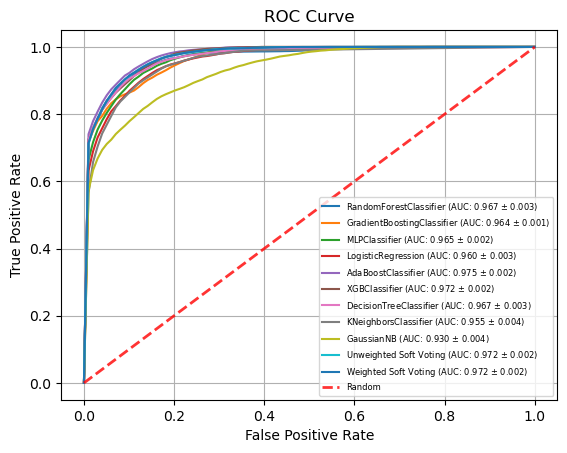

In [ ]:
# TODO plot ROC curve of best estimator

from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# define the cross validation folds
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create plot for each estimator
weights = [] # for soft voting 
for est_name, pipeline in (pbar := tqdm(best_pipelines)):
    pbar.set_description(f"Estimator: {est_name}")
    mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, pipeline, X_eval, y_eval, 1)
    plt.plot(
        mean_fpr,
        mean_tpr,
        label=f"{est_name} (AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f})",
    )
    weights.append(mean_auc)

# Add ensemble methods
# Soft Voting without weights
unweighted_soft_voting_clas = VotingClassifier(estimators=best_pipelines, voting="soft")
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, unweighted_soft_voting_clas, X_eval, y_eval, 1)
plt.plot(
    mean_fpr,
    mean_tpr,
    label=f"Unweighted Soft Voting (AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f})",
)

# Soft Voting with weights
weighted_soft_voting_clas = VotingClassifier(estimators=best_pipelines, voting="soft", weights=weights)
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, weighted_soft_voting_clas, X_eval, y_eval, 1)
plt.plot(
    mean_fpr,
    mean_tpr,
    label=f"Weighted Soft Voting (AUC: {mean_auc:.3f} $\pm$ {std_auc:.3f})",
)

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)

# Set plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

# Set plot legend
plt.legend(loc="lower right", fontsize=6)

# Save the plot

plt.savefig(f"roc_curve_p{str(fraction).replace('.', '')}.png", dpi=600)

# Show the plot
plt.grid(True)
plt.show() 

# TODO: Order after best results

### Confusion Matrix

0it [00:00, ?it/s]

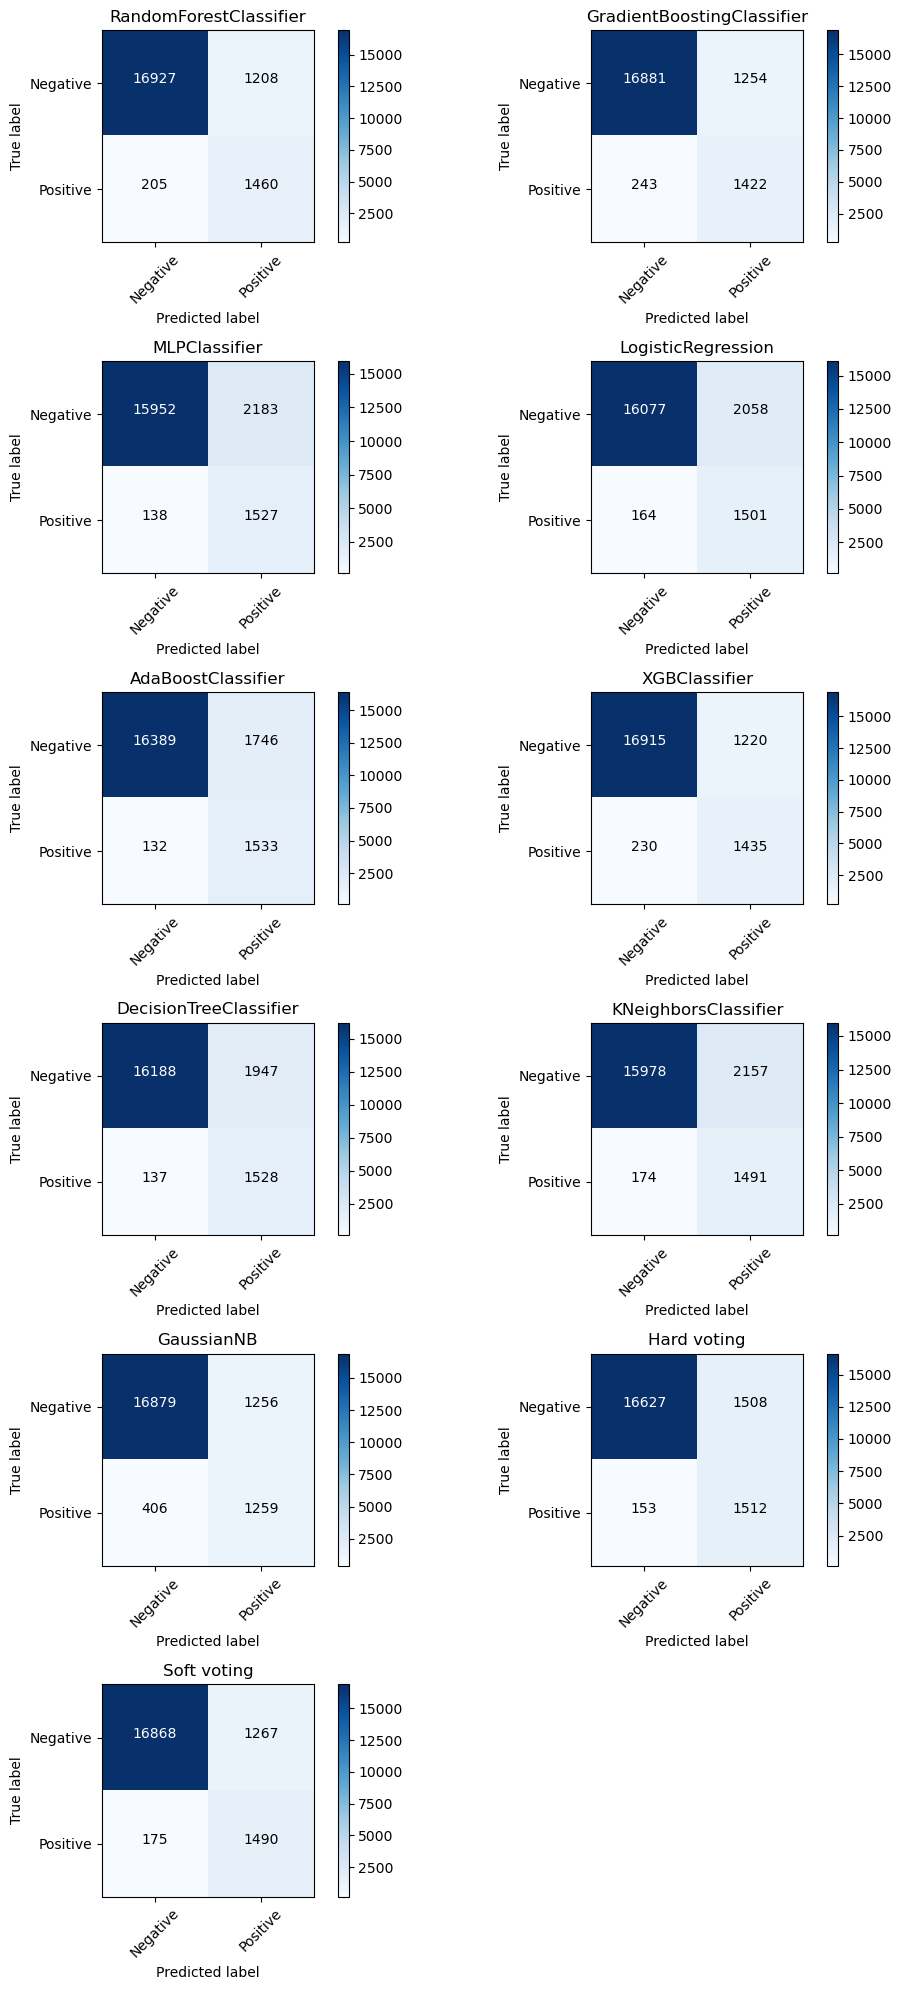

In [38]:
#  Plot confusion matrix for each estimator
plt.figure(figsize=(10,20))
for i, (est_name, pipeline) in (pbar := tqdm(enumerate(best_pipelines))):
    pbar.set_description(f"Estimator: {est_name}") # pbar is not working well

    pipeline.fit(X_train_eval, y_train_eval)
    plt.subplot(len(best_pipelines) // 2 + 2, 2, i+1)
    prediction = pipeline.predict(X_test_eval)
    cm = metrics.confusion_matrix(y_test_eval, prediction)
    plot_confusion_matrix(cm, classes=label_names, title=est_name)


    # print(cm)
    # print()

# Add ensemble classifier
hard_voting_clas = VotingClassifier(estimators=best_pipelines, voting="hard")
soft_voting_clas = VotingClassifier(estimators=best_pipelines, voting="soft")

hard_voting_clas.fit(X_train_eval, y_train_eval)
soft_voting_clas.fit(X_train_eval, y_train_eval)

prediction_hard = hard_voting_clas.predict(X_test_eval)
prediction_soft = soft_voting_clas.predict(X_test_eval)

cm_hard = metrics.confusion_matrix(y_test_eval, prediction_hard)
cm_soft = metrics.confusion_matrix(y_test_eval, prediction_soft)

# Plot confusion matrix for ensemble classifiers
plt.subplot(len(best_pipelines) // 2 + 2, 2, len(best_pipelines) + 1)
plot_confusion_matrix(cm_hard, classes=label_names, title="Hard voting")


plt.subplot(len(best_pipelines) // 2 + 2, 2, len(best_pipelines) + 2)
plot_confusion_matrix(cm_soft, classes=label_names, title="Soft voting")

plt.savefig(f"confusion_matrix_p{str(fraction).replace('.', '')}.png", dpi=600)

In [ ]:
# TODO: plot final decision tree
# Can other models be plotted?

In [ ]:
import pandas as pd
try:
    final_result = pd.read_csv(f"best_pipelines_p{str(fraction).replace('.', '')}.csv")
    final_result = final_result.iloc[:, 0:8]
    final_result['fraction'] = 0.01
    display(final_result)
except FileNotFoundError:
    pass

,Estimator,parameters,best_params,Scaler,Sampler,Clusterer,Feature Selector,Interaction feature,fraction
0,RandomForestClassifier,"{'max_depth': [3, 5, 7, 9, 11], 'criterion': ['gini', 'entropy'], 'n_estimators': [100, 200, 300, 400, 500]}","{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}",StandardScaler,OverSampler,passthrough,passthrough,passthrough,0.01
1,GradientBoostingClassifier,"{'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}","{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",StandardScaler,OverSampler,passthrough,SelectKBest,PolynomialFeatures,0.01
2,MLPClassifier,"{'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)]}","{'hidden_layer_sizes': (100, 100)}",StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.01
3,SVC,"{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}","{'C': 1, 'kernel': 'rbf'}",StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.01
4,LogisticRegression,"{'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}","{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",StandardScaler,UnderSampler,passthrough,passthrough,PolynomialFeatures,0.01
5,AdaBoostClassifier,"{'n_estimators': [100, 200, 300, 400, 500]}",{'n_estimators': 100},StandardScaler,UnderSampler,passthrough,passthrough,passthrough,0.01
6,XGBClassifier,"{'n_estimators': [100, 500], 'max_depth': [3, 7, 11]}","{'max_depth': 7, 'n_estimators': 100}",StandardScaler,OverSampler,passthrough,SelectKBest,passthrough,0.01
7,DecisionTreeClassifier,"{'max_depth': [3, 5, 7, 9, 11], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}","{'criterion': 'gini', 'max_depth': 11, 'splitter': 'best'}",RobustScaler,OverSampler,passthrough,SelectFpr,passthrough,0.01
8,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 7},StandardScaler,UnderSampler,passthrough,passthrough,PolynomialFeatures,0.01
9,GaussianNB,"{'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]}",{'var_smoothing': 1e-06},MinMaxScaler,OverSampler,passthrough,SelectPercentile,PolynomialFeatures,0.01


In [ ]:
# save f2 score of each estimator
f2_scores = []
for est_name, pipeline in (pbar := tqdm(best_pipelines)):
    pbar.set_description(f"Estimator: {est_name}") 
    pipeline.fit(X_train_eval, y_train_eval)
    prediction = pipeline.predict(X_test_eval)
    f2_scores.append({
        est_name: fbeta_score(y_test_eval, prediction, beta=2)
        })

# Add a new column 'F2-score' to the DataFrame
final_result['F2-score'] = None

# Update the 'F2-score' column with corresponding values from the dictionary
for item in f2_scores:
    key = list(item.keys())[0]  # Extract the estimator name (key)
    value = item[key]  # Extract the F2-score (value)
    final_result.loc[final_result['Estimator'] == key, 'F2-score'] = value

final_result.to_csv(f"final_results_p{str(fraction).replace('.', '')}.csv", index=False)
final_result

  0%|          | 0/9 [00:00<?, ?it/s]

,Estimator,parameters,best_params,Scaler,Sampler,Clusterer,Feature Selector,Interaction feature,fraction,F2-score
0,RandomForestClassifier,"{'max_depth': [3, 5, 7, 9, 11], 'criterion': ['gini', 'entropy'], 'n_estimators': [100, 200, 300, 400, 500]}","{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}",StandardScaler,OverSampler,passthrough,passthrough,passthrough,0.01,0.776903
1,GradientBoostingClassifier,"{'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]}","{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}",StandardScaler,OverSampler,passthrough,SelectKBest,PolynomialFeatures,0.01,0.761568
2,MLPClassifier,"{'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)]}","{'hidden_layer_sizes': (100, 100)}",StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.01,0.733004
3,SVC,"{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}","{'C': 1, 'kernel': 'rbf'}",StandardScaler,OverSampler,KMeans,SelectKBest,passthrough,0.01,None
4,LogisticRegression,"{'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}","{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",StandardScaler,UnderSampler,passthrough,passthrough,PolynomialFeatures,0.01,0.736556
5,AdaBoostClassifier,"{'n_estimators': [100, 200, 300, 400, 500]}",{'n_estimators': 100},StandardScaler,UnderSampler,passthrough,passthrough,passthrough,0.01,0.770859
6,XGBClassifier,"{'n_estimators': [100, 500], 'max_depth': [3, 7, 11]}","{'max_depth': 7, 'n_estimators': 100}",StandardScaler,OverSampler,passthrough,SelectKBest,passthrough,0.01,0.768818
7,DecisionTreeClassifier,"{'max_depth': [3, 5, 7, 9, 11], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}","{'criterion': 'gini', 'max_depth': 11, 'splitter': 'best'}",RobustScaler,OverSampler,passthrough,SelectFpr,passthrough,0.01,0.757394
8,KNeighborsClassifier,"{'n_neighbors': [3, 5, 7, 9, 11]}",{'n_neighbors': 7},StandardScaler,UnderSampler,passthrough,passthrough,PolynomialFeatures,0.01,0.724272
9,GaussianNB,"{'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]}",{'var_smoothing': 1e-06},MinMaxScaler,OverSampler,passthrough,SelectPercentile,PolynomialFeatures,0.01,0.685954


### Cost-based Evaluation